In [1]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import numpy as np
from numpy.random import choice

from gensim.models import Word2Vec

from cross_validation import cm2accuracy
from numpy import random
from sklearn.grid_search import GridSearchCV
%matplotlib inline

In [3]:
from features import buildData, getTitleAbstractBody
data, kwlist = buildData("marked_keywords")

In [154]:
data.shape

(491, 6)

In [155]:
t_keywords = [kwlist[i] for i in range(len(kwlist)) if data[i, -1] == 0]
m_keywords = [kwlist[i] for i in range(len(kwlist)) if data[i, -1] == 1]
a_keywords = [kwlist[i] for i in range(len(kwlist)) if data[i, -1] == 2]
o_keywords = [kwlist[i] for i in range(len(kwlist)) if data[i, -1] == 3]

t_inds = [i for i in range(len(kwlist)) if data[i, -1] == 0]
m_inds = [i for i in range(len(kwlist)) if data[i, -1] == 1]
a_inds = [i for i in range(len(kwlist)) if data[i, -1] == 2]
o_inds = [i for i in range(len(kwlist)) if data[i, -1] == 3]

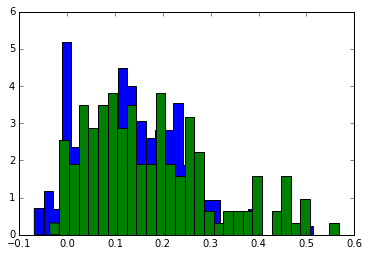

In [156]:
plt.hist(data[t_inds, -2], bins=30, normed=True)
plt.hist(data[m_inds, -2], bins=30, normed=True)
print ''

In [5]:
def countWords(kwlist):
    wordDict = {}
    for kw in kwlist:
        words = kw.lower().split()
        for w in words:
            if w not in wordDict:
                wordDict[w] = 1
            else: wordDict[w] += 1
    return wordDict

In [14]:

acc = 0.0


In [6]:
acc = 0.0
iters = 20
for i in range(iters):
    random.shuffle(data)

    rfc = RandomForestClassifier()
    #rfc = GradientBoostingClassifier()
    parameters = {'n_estimators':range(2, 20), 'max_depth':range(1,5)}

    gs = GridSearchCV(rfc, parameters)
    gs.fit(data[:300,:-1], data[:300,-1])

    bp = gs.best_params_



    clf = RandomForestClassifier(n_estimators=bp['n_estimators'], max_depth=bp['max_depth'])
    #clf = GradientBoostingClassifier(n_estimators=bp['n_estimators'], max_depth=bp['max_depth'])
    clf.fit(data[:300,:-1], data[:300,-1])
    preds = clf.predict(data[300:,:-1])
    cm = confusion_matrix(preds, data[300:,-1])
    acc += cm2accuracy(cm)

print acc/iters

KeyboardInterrupt: 

In [48]:
random.shuffle(data)
confusion_matrix(data[350:,-1], data[350:,-1])

array([[44,  0,  0,  0],
       [ 0, 27,  0,  0],
       [ 0,  0,  5,  0],
       [ 0,  0,  0, 12]])

In [86]:
scores = []
for size in np.linspace(30, 300, 28):
    inds = choice(range(300), size, replace=False)
    rfc = GradientBoostingClassifier()
    parameters = {'n_estimators':range(2, 10), 'max_depth':range(1,4)}
    gs = GridSearchCV(rfc, parameters, scoring="f1_micro")
    gs.fit(data[inds,:-1], data[inds,-1])
    bp = gs.best_params_
    
    clf = GradientBoostingClassifier(n_estimators=bp['n_estimators'], max_depth=bp['max_depth'])
    clf.fit(data[inds,:-1], data[inds,-1])
    score = clf.score(data[300:,:-1], data[300:,-1])
    scores.append(score) 
    print score
    print size

/home/dolorousrtur/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


0.557971014493
30.0
0.449275362319
40.0


KeyboardInterrupt: 

In [5]:
rfc = GradientBoostingClassifier()
#rfc = RandomForestClassifier()
parameters = {'n_estimators':range(10, 50, 5), 'max_depth':range(1,5)}
gs = GridSearchCV(rfc, parameters, scoring='f1_micro', cv=30)
gs.fit(data[:350,:-1], data[:350,-1])
bp = gs.best_params_

clf = GradientBoostingClassifier(n_estimators=bp['n_estimators'], max_depth=bp['max_depth'])
#clf = RandomForestClassifier(n_estimators=bp['n_estimators'], max_depth=bp['max_depth'])
clf.fit(data[:350,:-1], data[:350,-1])
preds = clf.predict(data[350:,:-1])

cm = confusion_matrix(data[350:,-1], preds)
print cm
print bp

[[58 15  0]
 [22 18  0]
 [20  8  0]]
{'n_estimators': 15, 'max_depth': 3}


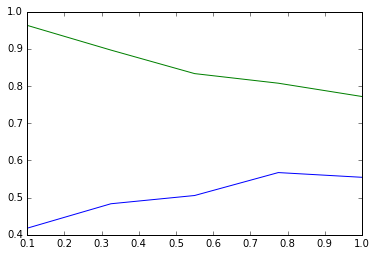

In [9]:
from sklearn.learning_curve import learning_curve

train_sizes = np.linspace(0.1, 1.0, 5)

clf = GradientBoostingClassifier(n_estimators=bp['n_estimators'], max_depth=3)
lc = learning_curve(clf, data[350:,:-1], data[350:,-1], scoring='f1_micro', train_sizes=train_sizes)
plt.plot(train_sizes, lc[2].mean(axis=1))
plt.plot(train_sizes, lc[1].mean(axis=1))

In [489]:
def loadCorporaSentences():
    s = 'all_docs_abstacts_refined/*.txt'
    filenames = glob.glob(s)
    sentences = []
        
    for filename in filenames:
        body = getTitleAbstractBody(filename)[2]
        sentences += text2sents(body)
    return sentences

In [69]:
import pickle
with open("article_sentences.pkl", 'r') as f:
    corpora = pickle.load(f)

In [32]:
m2 = Word2Vec.load('model.w2v')

In [127]:
from sklearn.metrics import f1_score, make_scorer

def fmeasureGBCLearningCurves(data, labels, parameters, train_sizes=np.linspace(0.1, 1.0, 5), n_folds=3):
    kfold = KFold(data.shape[0], n_folds=n_folds)
    
    clf = GradientBoostingClassifier()
    
    scores_test = np.zeros(len(train_sizes))
    scores_train = np.zeros(len(train_sizes))
    
    for test_inds, train_inds in kfold:
        train_data = data[train_inds]
        test_data = data[test_inds]
        train_labels = labels[train_inds]
        test_labels = labels[test_inds]
        i = 0
        for size in train_sizes:
            n_samples = int(train_data.shape[0]*size)
            train_data_shr = train_data[:n_samples]
            train_labels_shr = train_labels[:n_samples]
            
            grid = GridSearchCV(clf, parameters)
            grid.fit(train_data_shr, train_labels_shr)
            
            best_params = grid.best_params_
            
            gbc = GradientBoostingClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'])
            gbc.fit(train_data_shr, train_labels_shr)
            preds_test = gbc.predict(test_data)
            score_test = f1_score(preds_test, test_labels, average='micro')
            scores_test[i] += score_test
            
            preds_train = gbc.predict(train_data_shr)
            score_train = f1_score(preds_train, train_labels_shr, average='micro')
            scores_train[i] += score_train
            
            i+=1
            print i
    return scores_test/n_folds, scores_train/n_folds 

In [130]:
parameters = {'n_estimators':range(2, 20), 'max_depth':range(1,5)}
curve = fmeasureGBCLearningCurves(data[:,:-1], data[:,-1], parameters, n_folds=3)

1
2
3
4
5
1
2
3
4
5
1
2
3
4
5


In [208]:
stopwords = ['a', 'an', 'of', 'the', 'to', 'and', 'be', 'by']

def contains(list, sublist):
    if sublist[0] not in list:
        return False
    else:
        indices = [i for i, x in enumerate(list) if x == sublist[0]]
        for ind in indices:
            occ = True
            for i in range(len(sublist) - 1):
                if ind+1+i >= len(list):
                    break
                if list[ind+1+i] != sublist[i+1]:
                    occ = False
                    break
            if occ:
                return (ind, ind+len(sublist))
    return False

def getWindow(text, keyword, fr, to):
    sents = sent_tokenize(text)
    sents_tok = map(lambda x: filter(lambda y: any(c.isalpha() for c in y), word_tokenize(x)), sents)

    window = {}
    for i in range(fr, to+1):
        if i != 0:
            window[i] = []
    kw_splitted = keyword.split()

    for sent in sents_tok:
        bounds = contains(sent, kw_splitted)
        if bounds:
            window_st = max(0, bounds[0]+fr)
            window_end = min(len(sent), bounds[1]+to)
            for i in range(window_st, window_end):
                if i not in range(bounds[0], bounds[1]):
                    if i < bounds[0]:
                        pos = fr+(i - window_st)
                    else:
                        pos = fr+(i - window_st) - len(kw_splitted) + 1
                    word = sent[i]
                    if word not in stopwords:
                        window[pos].append(sent[i])
    return window

In [12]:
import os, re
import glob
import numpy as np
from gensim.models import Word2Vec
from nltk import sent_tokenize, word_tokenize
from features import *


def text_features(filename, keyword):
    """
    counts keyword's occurences in title, abstract, title and body
    :param filename: article filename
    :param keyword:
    :return: three integers: number of occurences in title, abstract and body
    """
    title, abstract, body = getTitleAbstractBody(filename)
    tcont = title.count(keyword)
    acont = abstract.count(keyword)
    bcont = body.count(keyword)
    if bcont > 0:
        pos = body.index(keyword)
        firstoc = float(len(re.findall('\ +', body[:pos])))/len(re.findall('\ +', body))
    else:
        firstoc = -1
    window_bef = getWindow(abstract, keyword, -1, 0) + getWindow(body, keyword, -1, 0)
    window_aft = getWindow(abstract, keyword, 0, 5) +  getWindow(body, keyword, 0, 5)
    
    usb = 'using' in window_bef 
    wib = 'with' in window_bef 
    propb = 'propose' in window_bef
    
    perf_b = 'perform' in window_bef 
    usa =  'using' in window_aft 
    return tcont, acont, firstoc, usb, wib, propb, perf_b, usa


def kw_windows(directory):
    data = []
    labels = {'T': 0, 'M': 1, 'A': 2, 'O': 3}
    kwlist = []
    s = '{}/*.key'.format(directory)
    filenames = glob.glob(s)
    for filename in filenames:
        kwords = getKeywords(filename, labels)

        rawFname = rawFilename(filename)
        for label in kwords:
            for kw in kwords[label]: 
                
                row =  + (label,)
                data.append(row)
                kwlist.append(kw)
    return np.array(data), kwlist

In [168]:
data, kwlist = buildDatal('marked_keywords')

t_inds = [i for i in range(len(kwlist)) if data[i, -1] == 0]
m_inds = [i for i in range(len(kwlist)) if data[i, -1] == 1]
a_inds = [i for i in range(len(kwlist)) if data[i, -1] == 2]
o_inds = [i for i in range(len(kwlist)) if data[i, -1] == 3]

In [174]:
inds = m_inds

print float(len([i for i in inds if data[i, 3] == 1]))/len(inds) * 1000
print float(len([i for i in inds if data[i, 4] == 1]))/len(inds) * 1000
print float(len([i for i in inds if data[i, 5] == 1]))/len(inds) * 1000
print float(len([i for i in inds if data[i, 6] == 1]))/len(inds) * 1000
print float(len([i for i in inds if data[i, 7] == 1]))/len(inds) * 1000

25.641025641
51.2820512821
0.0
0.0
25.641025641


In [210]:
from nltk import sent_tokenize, word_tokenize

fr = -5
to = 5

keyword = "throughput bounds"

text = getTitleAbstractBody("marked_keywords/104888.txt")[2]

getWindow(text, keyword, -5, 5)

{-5: ['upper', 'non-ergodic', 'in'],
 -4: ['computed', 'bounds'],
 -3: ['for', 'for', 'computation', 'choice'],
 -2: ['their'],
 -1: ['steady-state', 'steady-state', 'computing'],
 1: ['makes', 'instead'],
 2: ['sense'],
 3: ['actual'],
 4: ['values'],
 5: ['is']}

In [50]:
import glob
import numpy as np
from sklearn.metrics import confusion_matrix
from cross_validation import cm2accuracy

data = []

def kw_labels_list(directory, labelmap):
    keywords = []
    labels = []
    s = '{}/*.key'.format(directory)
    filenames = glob.glob(s)
    for filename in filenames:
            kwords = getKeywords(filename, labelmap)            
            for label in kwords:
                for kw in kwords[label]:
                        ind = filename.index('/')
                        keywords.append([filename[ind+1:], kw])
                        labels.append(label)
    return keywords, labels

def combined_markings(labelmap, directories):
    kw_0, l_0 = kw_labels_list(directories[0], labelmap)
    labeltab = np.array(l_0)
    for i in range(1, len(directories)):
        kws, ls = kw_labels_list(directories[i], labelmap)
        ls = np.array([ls[kws.index(w)] for w in kw_0])
        labeltab = np.column_stack((labeltab, ls))
    return kw_0, labeltab

def mismarked_kws(cl_0, cl_1, kwlist, labels_0, labels_1):
    kws = [kwlist[i] for i in range(len(kwlist)) if labels_0[i] == cl_0 and labels_1[i] == cl_1]
    return kws

def print_agreement(labelmap, outfilename, directories):
    kws, labeltab = combined_markings(labelmap, directories)
    
    with open(outfilename, 'w+') as f:
        st = "{}\t{}\t{}\n"
        for i in range(len(kw_val)):
            for j in range(labeltab.shape[1]):
                f.write(st.format(j, i, labeltab[i,j]))

In [53]:
print_agreement(labels, "../agreement/agr_data.txt", ("marked_keywords_nc", "marked_val"))

In [13]:
labels = {'T': 0, 'M': 1, 'O': 2}
kw_m, labels_m = kw_labels_list("marked_keywords_nc", labels)
kw_val, labels_val = kw_labels_list("marked_val", labels)

m_labels = [labels_m[kw_m.index(i)] for i in kw_val]

cm = confusion_matrix(m_labels, labels_val)
print cm
print cm2accuracy(cm)

[[32  3  0]
 [ 2 17  3]
 [ 5  3 15]]
0.8


In [133]:
sum(1 for i in m_labels if i == 0)

34

In [138]:
m_labels_no3 = [m_labels[i] for i in  range(len(m_labels)) if  m_labels[i] != 2 and labels_val[i] != 2]
val_labels_no3 = [labels_val[i] for i in  range(len(m_labels)) if m_labels[i] != 2 and labels_val[i] != 2]

In [113]:
cm = confusion_matrix(m_labels_no3, val_labels_no3)
print cm
print cm2accuracy(cm)

[[30  3]
 [ 2 17]]
0.903846153846


In [140]:
mismarked_kws(2, 0, kw_val, m_labels, labels_val)

[['102375.key', 'formal specification'],
 ['102375.key', 'program debugging'],
 ['116694.key', '3D model'],
 ['103149.key', 'dense output'],
 ['123208.key', 'packet switching']]

In [144]:
with open('agr_data.txt', 'w+') as f:
    st = "{}\t{}\t{}\n"
    for i in range(len(kw_val)):
        f.write(st.format('a', i, m_labels[i]))
        f.write(st.format('b', i, m_labels[i]))

In [64]:
kws,ls = combined_markings(labels, ("marked_keywords_nc", "marked_val"))

In [69]:
import agreement


def getAgreement(labels, directories, metric='alpha'):
    kws,ls = combined_markings(labels, directories)
    data = agreement.DataSet(agreement.binary_distance)
    vals = []
    for item in range(ls.shape[0]):
        for coder in range(ls.shape[1]):
            vals.append("%s_%s_%s"%(coder,item, ls[item, coder]))        
    data.load_array(vals,':')
    return data.get(metric)

In [70]:
getAgreement(labels, ("marked_keywords_nc", "marked_val"))

0.6900962358387136